<div>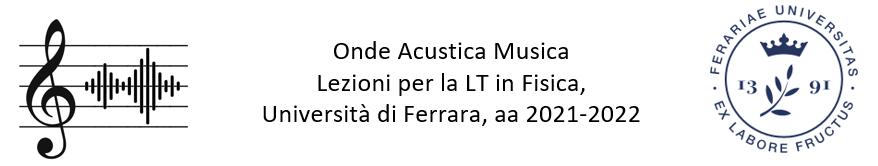</div>


# Lab 1. Signals & Sounds, and the Uncertainty Relation

In this first lab, we generate some synthetic sounds and perform some time-frequency analysis. We will _hear_ the Uncertainty "Principle" (or better, Relation) at work.

In [1]:
# standard python libs for math, signal processing and plotting
import numpy as np
import scipy.signal as ss
import matplotlib.pyplot as plt
from math import log10

# python libs for the notebook interaction
from ipywidgets import interact
import ipywidgets as widgets

# custom modules
import scipy.io.wavfile as wav
import simpleaudio as sa   # generates sounds
from tftb.processing import Spectrogram   # computes a time-frequency "map" of a signal

# with the following, the plots are opened as separate windows in full resolution
%matplotlib

fs = 44100        # sampling frequency in audio cards is 44.1 kHz for CD-quality audio
samples = 65536   # samples used for the FFT

Using matplotlib backend: Qt5Agg


## The Fourier Transform

### Theory recap

The Fourier Transform $S(f)$ of a time-dependent signal $s(t)$ is defined as:

$$S(f) := \int_{-\infty}^{+\infty}s(t)e^{-i 2\pi ft}dt$$

The Fourier Transform operator $F$ is a linear operator with several interesting properties. Let's recall a few.

1) Transforming a monochromatic signal of frequency $f_0$ (including $f_0 = 0$, i.e. a constant function) yields the Dirac delta distribution, and on the contrary transforming a Dirac delta yields a constant:

$$s(t) = e^{i 2\pi f_0 t} \Rightarrow S(f) = \delta(f - f_0)$$

$$s(t) = \delta(t) \Rightarrow S(f) = 1$$

2) Transforming a Gaussian signal yields another Gaussian, i.e. the gaussian is an _eigenfunction_ of the Fourier operator:

$$s(t) = \frac{1}{\sqrt{2\pi\sigma^2}}e^{-t^2 / 2\sigma^2} \Rightarrow S(f) = e^{-2\pi^2\sigma^2 f^2}$$

Note how the transformed Gaussian has a standard deviation proportional to $\sigma^{-1}$.

3) The _convolution_ or _cross-correlation_ of two signals gets transformed to the product of their transforms, and vice versa:

$$c(t) := (s_1 \ast s_2)(t) = \int_{-\infty}^{+\infty}s_1(\tau) \cdot s_2(t-\tau)d\tau \Rightarrow C(f) = S_1(f) \cdot S_2(f)$$
$$p(t) := s_1(t) \cdot s_2(t) \Rightarrow P(f) = (S_1 \ast S_2)(f)$$

3.1) It follows that the _autocorrelation_ of a signal is transformed to the _power spectral density_ of that signal:

$$r(t) := (s \ast \overline{s})(t) = \int_{-\infty}^{+\infty}s(\tau)\cdot \overline{s(t-\tau)}d\tau \Rightarrow R(f) = |S(f)|^2$$

3.2) It also follows that the Dirac delta is the unit for the $\ast$ operator. Therefore, a monochromatic signal enveloped by a *window* signal gets transformed to the Fourier transform of the window, shifted by the signal frequency:

$$s(t) = w(t) \cdot e^{i 2\pi f_{0}t} \Rightarrow S(f) = W(f) \ast \delta(f - f_0) = W(f - f_0)$$

4) Given $s\bar{}(t) := s(-t)$, the following applies:

$$F^2(s) = s\bar{}; F^3(S) = s; F^4(s) = s$$

That is, $F$ is a "cyclic" operator with $F^3$ equivalent to its inverse. The Inverse Fourier Transform can be directly defined as:

$$s(t) = \int_{-\infty}^{+\infty}S(f)e^{i 2\pi ft}df$$

The Discrete Fourier Transform $S(m)$ of a finite sequence $s(n)$ is defined as:

$$S(k) = \sum_{n=0}^{N-1}s(n)e^{-i2\pi kn/N} \quad k = 0, 1, ..., N-1$$

Where $N$ is the length of the $s(n)$ sequence, as well as the length of the $S(m)$ sequence of frequency samples.

### Testing live

Let's explore some of those properties live. The code below comes from Lab 0, and the `quantizeandplay()` function is a simple quantizer to play the signal with either 8-bit or 16-bit levels. Note that the quantization process introduces an error equal to half the least significant bit, therefore the Signal-to-Noise ratio (SNR) is:

$$SNR_{dB} = 2 \cdot 10 \space log_{10}(2^n) \approx 6n \space [dB]$$

Where $n$ is the number of bits. Therefore with 8 bit (typical for radio-quality or mobile-phone-quality audio), the SNR is 48 dB. With 16 bit (the standard for CD-quality audio), the SNR is 96 dB.

In [2]:
def plottimefreq(s, duration, small=False):
    # plot the time series of the signal s
    plt.subplots(figsize=(25, 5)) 
    ax = plt.subplot(1, 3 - int(small), 1)
    plt.plot(np.real(s))
    plt.xlim(0)
    ax.set_xlabel('t [ms]')
    maxx = int(duration*10 + 1)*100
    ax.set_xticks(np.arange(0, maxx*fs/1000, maxx*fs/10000, dtype=int))
    ax.set_xticklabels(np.arange(0, maxx, maxx/10, dtype=int))
    plt.grid(which='major')
    plt.title("Wave packet")

    # also compute and plot power spectral density
    ax = plt.subplot(1, 3 - int(small), 2)
    s = np.pad(s, (0, samples-s.size), mode='constant')
    W = np.abs(np.fft.fft(s) ** 2)
    f = np.fft.fftfreq(s.size, 1/fs)
    plt.plot(f, W)
    plt.xlim(20, 10000)
    #formatter = LogFormatter(labelOnlyBase=False, minor_thresholds=(1, 0.1))
    #ax.get_xaxis().set_minor_formatter(formatter)
    ax.set_xlabel('f [Hz]')
    plt.ylim(1E-4)
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(which='both')
    plt.title("Power spectral density (log/log)")
    plt.show()

In [3]:
def quantizeandplay(s, quant):
    if quant not in [4, 8, 16]:
        raise Exception('Unsupported quantization')
    qfactor = (2**(quant-1) - 1) * 1.0 / np.max(np.abs(s))
    playable = s * qfactor
    playable = playable.astype(np.int16 if quant == 16 else np.int8)
    # stop any ongoing play
    sa.stop_all()
    # play on a single audio channel with either 1 or 2 bytes per sample according to the quantization
    sa.play_buffer(playable, 1, 2 if quant == 16 else 1, fs)
    # rescale the quantized signal
    return playable.astype(float) / qfactor

The interactive code below creates simple audio signals, plays them and shows the plots from the above function

In [4]:
@interact(f=widgets.FloatLogSlider(min=log10(20), max=log10(20000), value=200, continuous_update=False),
          duration=widgets.FloatSlider(min=0.01, max=1.48, value=1, step=0.01, continuous_update=False),
          quantization=widgets.RadioButtons(options=[None, 16, 8, 4]),
         )
def playwavelet(f, duration, quantization):
    t = np.linspace(0, duration, int(duration * fs), False)

    # generate the wave
    s = np.sin(2 * np.pi * f * t)

    # play it if required, and plot it
    if not quantization:
        q = s
    else:
        q = quantizeandplay(s, quantization)
    plottimefreq(q, duration)

interactive(children=(FloatLogSlider(value=200.0, continuous_update=False, description='f', max=4.301029995663…

## The Uncertainty Relation in action

Without loss of generality, we consider square-integrable functions $s$ with null average:

$$\mu(s) := \frac{ \int_{-\infty}^{+\infty}x |s(x)|^2dx }{ \int_{-\infty}^{+\infty}|s(x)|^2dx } = 0$$

The second moment or variance of the function is defined as:

$$\sigma^2(s) := \frac{ \int_{-\infty}^{+\infty}x^2 |s(x)|^2dx }{ \int_{-\infty}^{+\infty}|s(x)|^2dx }$$

Using the Cauchy-Schwartz inequality for functions in $L^2$, it can be proven that:

$$||\textbf{s}||^2 \cdot ||\textbf{S}||^2 \equiv \sigma^2(s) \cdot \sigma^2(S) \ge \frac{1}{16\pi^2} \equiv |\left\langle\textbf{s}, \textbf{S}\right\rangle|^2$$

Furthermore, it can be proven that the equality holds for a Gaussian signal. Using $\sigma_t$ and $\sigma_f$ for the standard deviations:

$$\sigma_t \cdot \sigma_f = \frac{1}{4\pi}$$

Introducing $\omega = 2 \pi f$, we can write as well:

$$\sigma_t \cdot \sigma_\omega \ge \frac{1}{2}$$

Compare this with the *Heisenberg Uncertainty Principle*:

$$\sigma_x \cdot \sigma_k \ge \frac{1}{2}$$
$$\sigma_x \cdot \sigma_p \ge \frac{h}{4\pi} = \frac{\hbar}{2}$$

In the following, we plot a "single-frequency" wavelet and its power spectral density, and compare their time vs. frequency spreads:

* by varying the duration of the wavelet
* by varying the enveloping or windowing signal (*rectangular* i.e. no window, *Hann*, *Hamming*, or *Gaussian*)
* by varying the fraction of the signal that is smoothed by the window

We can "see" how a short time spread yields a large frequency spread, and we can "hear" how the sound progressively becomes a *tic* with no clear pitch!
Also, note how the absence of a windowing signal produces a *click* at the beginning and at the end of the signal, whereas the smoothest sound comes with the Gaussian windowing.

In [5]:
@interact(f=widgets.FloatLogSlider(min=log10(20), max=log10(20000), value=100, continuous_update=False),
          duration=widgets.FloatSlider(min=0.01, max=1.48, value=0.6, step=0.01, continuous_update=False),
          window=widgets.RadioButtons(options=['rect', 'hann', 'hamming', 'gaussian']),
          gauss_stdev=widgets.IntSlider(min=100, max=8000, value=5000, continuous_update=False),
          win_frac=widgets.FloatSlider(min=0.01, max=1.00, value=1.00, step=0.01, continuous_update=False),
          quantization=widgets.RadioButtons(options=[None, 16, 8, 4]),
         )
def playwavelet(f, duration, window, gauss_stdev, win_frac, quantization):
    t = np.linspace(0, duration, int(duration * fs), False)

    # generate the fundamental wave
    s = np.sin(2 * np.pi * f * t)
    # use a window to smooth begin and end
    if window == 'hann':
        w = np.hanning(s.size * win_frac)
    elif window == 'hamming':
        w = np.hamming(s.size * win_frac)
    elif window == 'gaussian':
        w = ss.gaussian(int(s.size * win_frac), duration*win_frac*gauss_stdev)
    if window != 'rect':
        # apply the window at the ramp up and ramp down of the signal
        for i in range(int(w.size/2)):
            s[i] *= w[i]
            s[s.size-int(w.size/2)+i] *= w[int(w.size/2)+i]

    # play it if required, and plot it
    if not quantization:
        p = s
    else:
        p = quantizeandplay(s, quantization)
    plottimefreq(p, duration)

interactive(children=(FloatLogSlider(value=100.0, continuous_update=False, description='f', max=4.301029995663…

### Time-Frequency Analysis

The energy distribution of a transient signal can be obtained for instance with the *spectrogram*, defined from the *Short-Time Fourier Transform*:

$$ S_{st}(t, f) = \int_{-\infty}^{+\infty}s(\tau)w(\tau-t)e^{-i 2\pi f\tau}d\tau$$

Where $w(t)$ is a windowing function, typically Hamming or Gaussian. The spectrogram is defined as $|S_{st}(t, f)|^2$.

The Uncertainty Principle can be seen at play in the time-frequency plane as the "area" occupied by a signal cannot be arbitrarily small: a signal can either be localized over the $t$ axis or over the $f$ axis, not both. Again, the maximum localization in both axis, i.e. the minimal area, is achieved with a Gaussian signal.

In [7]:
@interact(f=widgets.FloatLogSlider(min=log10(100), max=log10(1000), value=300, continuous_update=False),
          duration_ms=widgets.IntSlider(min=1, max=500, value=100, step=1, continuous_update=False),
          window=widgets.RadioButtons(options=['rect', 'hann', 'hamming', 'gaussian']),
          win_frac=widgets.FloatSlider(min=0.01, max=1.00, value=1.00, step=0.01, continuous_update=False),
         )
def playwavelet(f, duration_ms, window, win_frac):
    t = np.linspace(0, duration_ms/1000, int(duration_ms/1000 * fs), False)

    # generate the fundamental wave
    s = 1000 * np.sin(2 * np.pi * f * t)
    # use a window to smooth begin and end
    if window == 'hann':
        w = np.hanning(s.size * win_frac)
    elif window == 'hamming':
        w = np.hamming(s.size * win_frac)
    elif window == 'gaussian':
        w = ss.gaussian(int(s.size * win_frac), duration_ms*win_frac*4)
    if window != 'rect':
        # apply the window at the ramp up and ramp down of the signal
        for i in range(int(w.size/2)):
            s[i] *= w[i]
            s[s.size-int(w.size/2)+i] *= w[int(w.size/2)+i]
    
    # pad the signal, resample to speed up computation, and compute the spectrogram
    # the window function is 200 times shorter than the input signal to accurately "explore" it
    padding = int((samples/2-s.size)/2)
    sp = Spectrogram(ss.resample(np.pad(s, (padding, padding), mode='constant'), 2048), 
                     fwindow=np.hamming(int(s.size/100)+1))   # ss.gaussian(int(s.size/200)+1, 3) as an alternative
    sp.run()
    sp.plot(kind='contour', scale='log', threshold=0.01)

    # add the usual time domain and frequency domain plots for reference
    plottimefreq(s, duration_ms/1000, small=True)


interactive(children=(FloatLogSlider(value=300.0, continuous_update=False, description='f', max=3.0, min=2.0),…

Let's analyze now the Spetrogram of a real sound, like the _Do_ note we analyzed in Lab 0. First we load it with the same code we have seen:

In [13]:
fileaudio = wav.read('Do_piano_reverb.wav')
datanp = np.array(fileaudio[1], dtype=float)
fs = fileaudio[0]
plottimefreq(datanp[:65536], 1)
quantizeandplay(datanp, 16)

array([ 87.00265511,  95.00289926, 100.00305185, ...,   0.        ,
         0.        ,   0.        ])

Now we have our signal, but it is too large to launch a STFT! We must _resample_ it 

In [14]:
fr = 8000      # resampling frequency = 8 kHz
resampled = ss.resample(datanp, int(fr/fs * datanp.size))
fs = fr
resampled = quantizeandplay(resampled, 16)
plottimefreq(resampled[:12000], 1)
fs = 44100

In [15]:
# the window function is ~100 times shorter than the input signal to accurately "explore" it
sp = Spectrogram(resampled[:12000], fwindow=np.hamming(100))
sp.run()
sp.plot(kind='contour', scale='log', threshold=0.003)